# 1.1 학습된 VGG 모델을 사용하는 방법

- 학습된 VGG 모델을 사용하여, 미지의 화상(골든 리트리버)를 분류합니다


# 학습 목표

1. PyTorch로 ImangeNet 데이터 세트에서 학습된 모델을 로드한다
2. VGG 모델을 이해한다
3. 입력 화상의 크기와 색상을 변환할 수 있다



# 사전 준비


1. 도서의 지시대로 make_folders_and_data_downloads.ipynb를 실행해 이 장에서 사용하는 데이터를 다운로드


2. PyTorch 설치( https://pytorch.org/get-started/locally/ )를 참고하여, PyTorch 1.0을 설치


conda install pytorch-cpu torchvision-cpu -c pytorch

(Windows (GPU 없음) 환경에서 conda를 사용해 PyTorch를 설치하는 경우)


3. Matplotlib를 설치

conda install -c conda-forge matplotlib 


# 패키지 import 및 PyTorch 버전 확인

In [14]:
# 패키지 import
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import models, transforms


In [15]:
# PyTorch 버전 확인
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


PyTorch Version:  1.1.0
Torchvision Version:  0.3.0


# 학습된 VGG-16모델을 읽기

In [16]:
# 학습된 VGG-16 모델을 읽기
# 처음 실행할 때에는 학습된 파라미터를 다운로드하므로 실행에 시간이 걸립니다

# VGG-16 모델의 인스턴스를 생성
use_pretrained = True  # 학습된 파라미터를 사용
net = models.vgg16(pretrained=use_pretrained)
net.eval()  # 추론 모드(평가 모드)로 설정

# 모델의 네트워크 구성을 출력
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# 입력 화상의 전처리 클래스를 작성

In [17]:
# 입력 화상의 전처리 클래스
class BaseTransform():
    """
    화상의 크기를 리사이즈하고 색상을 표준화한다.

    Attributes
    ----------
    resize : int
        리사이즈 대상 이미지의 크기.
    mean : (R, G, B)
        각 색상 채널의 평균 값.
    std : (R, G, B)
        각 색상 채널의 표준 편차.
    """

    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize),  # 짧은 변의 길이가 resize의 크기가 된다
            transforms.CenterCrop(resize),  # 이미지 중앙을 resize × resize으로 자르기
            transforms.ToTensor(),  # Torch 텐서로 변환
            transforms.Normalize(mean, std)  # 색상 정보의 표준화
        ])

    def __call__(self, img):
        return self.base_transform(img)


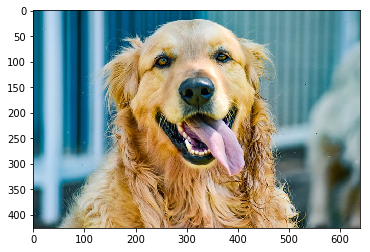

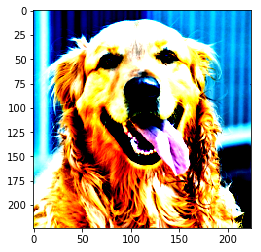

In [18]:
# 이미지 전처리 동작 확인

# 1. 화상 읽기
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)  # [높이][너비][색RGB]

# 2. 원본 화상 표시
plt.imshow(img)
plt.show()

# 3. 화상 전처리 및 처리된 이미지의 표시
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
transform = BaseTransform(resize, mean, std)
img_transformed = transform(img)  # torch.Size([3, 224, 224])

# (색상, 높이, 너비)을(높이, 너비, 색상)으로 변환하고 0-1로 값을 제한하여 표시
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()


# 출력 결과에서 라벨을 예측하는 후처리 클래스를 작성

In [19]:
# ILSVRC 라벨 정보를 읽어 사전형 변수를 생성합니다
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))
ILSVRC_class_index


n02823428', 'beer_bottle'],
 '441': ['n02823750', 'beer_glass'],
 '442': ['n02825657', 'bell_cote'],
 '443': ['n02834397', 'bib'],
 '444': ['n02835271', 'bicycle-built-for-two'],
 '445': ['n02837789', 'bikini'],
 '446': ['n02840245', 'binder'],
 '447': ['n02841315', 'binoculars'],
 '448': ['n02843684', 'birdhouse'],
 '449': ['n02859443', 'boathouse'],
 '450': ['n02860847', 'bobsled'],
 '451': ['n02865351', 'bolo_tie'],
 '452': ['n02869837', 'bonnet'],
 '453': ['n02870880', 'bookcase'],
 '454': ['n02871525', 'bookshop'],
 '455': ['n02877765', 'bottlecap'],
 '456': ['n02879718', 'bow'],
 '457': ['n02883205', 'bow_tie'],
 '458': ['n02892201', 'brass'],
 '459': ['n02892767', 'brassiere'],
 '460': ['n02894605', 'breakwater'],
 '461': ['n02895154', 'breastplate'],
 '462': ['n02906734', 'broom'],
 '463': ['n02909870', 'bucket'],
 '464': ['n02910353', 'buckle'],
 '465': ['n02916936', 'bulletproof_vest'],
 '466': ['n02917067', 'bullet_train'],
 '467': ['n02927161', 'butcher_shop'],
 '468': ['n0

In [20]:
# 출력 결과에서 라벨을 예측하는 후처리 클래스
class ILSVRCPredictor():
    """
    ILSVRC 데이터에 대한 모델의 출력에서 라벨을 구한다.

    Attributes
    ----------
    class_index : dictionary
            클래스 index와 라벨명을 대응시킨 사전형 변수.
    """

    def __init__(self, class_index):
        self.class_index = class_index

    def predict_max(self, out):
        """
        최대 확률의 ILSVRC 라벨명을 가져옵니다.

        Parameters
        ----------
        out : torch.Size([1, 1000])
            Net에서의 출력.

        Returns
        -------
        predicted_label_name : str
            가장 예측 확률이 높은 라벨명
        """
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]

        return predicted_label_name


# 학습된 VGG 모델로 화상 예측

In [22]:
# ILSVRC 라벨 정보를 읽어 사전형 변수를 생성
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))

# ILSVRCPredictor 인스턴스 생성
predictor = ILSVRCPredictor(ILSVRC_class_index)

# 입력 화상 읽기
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)  # [높이][너비][색RGB]

# 전처리 후, 배치 크기의 차원을 추가
transform = BaseTransform(resize, mean, std)  # 전처리 클래스 작성
img_transformed = transform(img)  # torch.Size([3, 224, 224])
inputs = img_transformed.unsqueeze_(0)  # torch.Size([1, 3, 224, 224])

# 모델에 입력하고, 모델 출력을 라벨로 변환
out = net(inputs)  # torch.Size([1, 1000])
result = predictor.predict_max(out)

# 예측 결과를 출력
print("입력 화상의 예측 결과: ", result)


입력 화상의 예측 결과:  golden_retriever


끝